Using device: cuda


An error occurred while trying to fetch Abhi5ingh/model_dresscode: Abhi5ingh/model_dresscode does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Enter the URL of the sketch: https://huggingface.co/Abhi5ingh/ControlnetDresscode/resolve/main/image_control.png
Enter the design description: one-shoulder  dress one long draping sleeve one sleeved mini red evening dress


  0%|          | 0/50 [00:00<?, ?it/s]

Prompt:	one-shoulder  dress one long draping sleeve one sleeved mini red evening dress. The design should be photorealistic, with cinematic lighting and hyper-realistic details. Use innovative and high-tech elements in the design.
Seed:	8688337627419181643


""

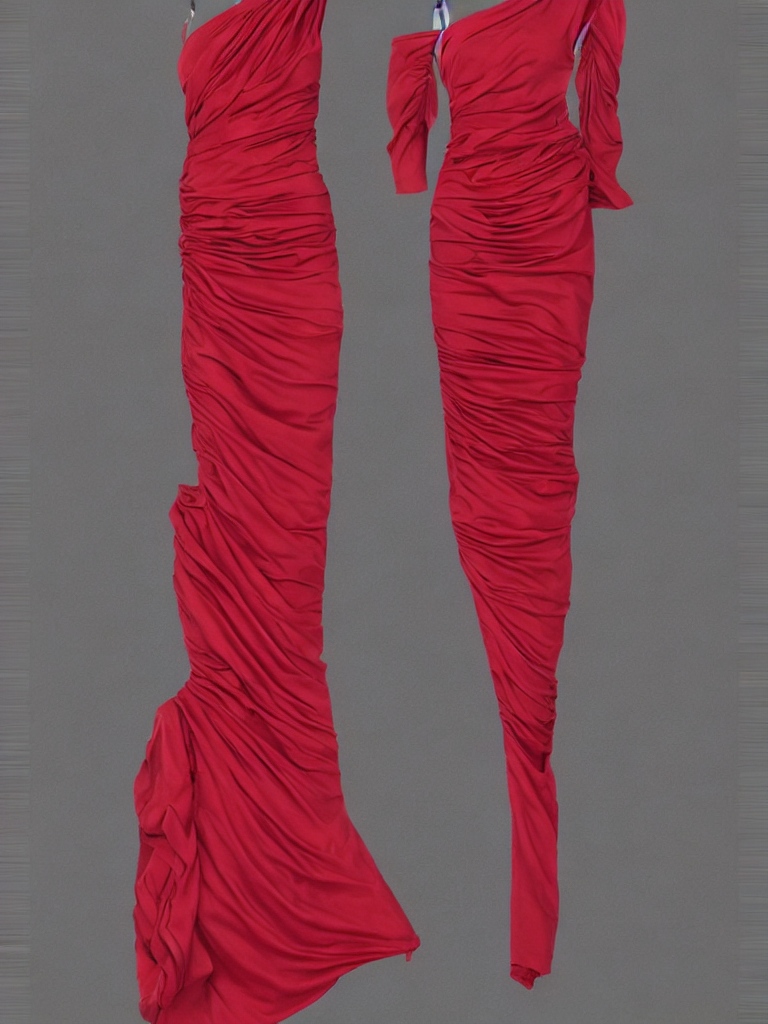

In [ ]:
# Install necessary libraries
!pip install --quiet diffusers transformers accelerate mediapy torch

import mediapy as media
import random
import sys
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from PIL import Image, UnidentifiedImageError
import requests
from io import BytesIO
import numpy as np

# Check if CUDA is available and set the device accordingly
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load the controlnet model and the pipeline
controlnet = ControlNetModel.from_pretrained("Abhi5ingh/model_dresscode", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16)
pipe = pipe.to(device)

# Function to load an image from a URL
def load_image(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content)).convert("RGB")
        return image
    except (requests.exceptions.RequestException, UnidentifiedImageError) as e:
        print(f"Error loading image: {e}")
        return None

# Input sketch URL
sketch_url = input("Enter the URL of the sketch: ") # example: https://example.com/sketch.jpg
sketch_image = load_image(sketch_url)

# Check if the image was successfully loaded
if sketch_image is None:
    print("Failed to load the sketch image. Please check the URL and try again.")
else:
    # Solicit information from the user
    description = input("Enter the design description: ") # example: "A stylish modern dress"

    # Create the prompt based on user input
    prompt = f"{description}. The design should be photorealistic, with cinematic lighting and hyper-realistic details. Use innovative and high-tech elements in the design."

    # Convert the sketch image to a tensor and ensure it has the correct dtype
    sketch_array = np.array(sketch_image).astype(np.float16) / 255.0
    sketch_tensor = torch.tensor(sketch_array).permute(2, 0, 1).unsqueeze(0).to(device)

    # Generate the design
    seed = random.randint(0, sys.maxsize)
    num_inference_steps = 50
    images = pipe(prompt=prompt, image=sketch_tensor, guidance_scale=7.5, num_inference_steps=num_inference_steps, generator=torch.Generator(device).manual_seed(seed)).images

    # Display the generated design
    print(f"Prompt:\t{prompt}\nSeed:\t{seed}")
    media.show_images(images)
    images[0].save("output.jpg")
